In [2]:
!unzip /content/Midi.zip -d path_to_directory

Archive:  /content/Midi.zip
replace path_to_directory/Midi/Aaron_Colin_Adams_-_Sonic_1-Mystery_Caves_Zone.mid? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: path_to_directory/Midi/Aaron_Colin_Adams_-_Sonic_1-Mystery_Caves_Zone.mid  
  inflating: path_to_directory/Midi/Animenz_-_This_game.mid  
  inflating: path_to_directory/Midi/Animenz_-_This_game_By_Animenz.mid  
  inflating: path_to_directory/Midi/Animenz_-_This_game_by_Animez_in_C_piano.mid  
  inflating: path_to_directory/Midi/Animenz_-_This_game_OP_Animenz_In_C.mid  
  inflating: path_to_directory/Midi/Animenz_-_This_Game_OP_Animenz_In_Eb.mid  
  inflating: path_to_directory/Midi/Animenz_-_This_game_op_by_Animenz_in_Eb_(Modify).mid  
  inflating: path_to_directory/Midi/Animez__-_This_Game_(In_E_flat_Advanced_Version)(re-modify).mid  
  inflating: path_to_directory/Midi/Arata_Iiyoshi_-_Primal_Dialga_Battle.mid  
  inflating: path_to_directory/Midi/Arrangement_-_Binding_of_Isaac_-_Ukulele_Arrangement.mid  
  inflating: path_

In [6]:
#courtesy of https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/
from music21 import *
import os
import numpy as np
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K
from keras.models import load_model
import random


In [7]:
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over all the instruments
    if s2 == None:
      pass
    else:
      try:
        for part in s2.parts:
        
            #select elements of only piano
            if 'Piano' in str(part): 
            
                notes_to_parse = part.recurse() 
          
                #finding whether a particular element is note or a chord
                for element in notes_to_parse:
                    
                    #note
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    
                    #chord
                    elif isinstance(element, chord.Chord):
                        notes.append('.'.join(str(n) for n in element.normalOrder))
      except:
          pass

    return np.array(notes)

In [8]:
#specify the path
path='/content/path_to_directory/Midi/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: /content/path_to_directory/Midi/Benjy_shelton__-_Conker's_bad_fur_day_big_poop.mid
Loading Music File: /content/path_to_directory/Midi/Nintendo_-_Mii_Channel_Song.mid
Loading Music File: /content/path_to_directory/Midi/Nintendo_-_Pokemon_Fire_Red_Pallet_Town_Theme_(2_Times).mid
Loading Music File: /content/path_to_directory/Midi/Video_Game_Themes_-_Street_Fighter_2.mid
Loading Music File: /content/path_to_directory/Midi/Nintendo_-_Pokemon_Liquid_Crystal_Violet_City_Piano_Cover.mid
Loading Music File: /content/path_to_directory/Midi/Nintendo_-_Pokemon_FRLG_Battle_Gym_Leader.mid
Loading Music File: /content/path_to_directory/Midi/Toby_Fox_-_The_world_revolution.mid
Loading Music File: /content/path_to_directory/Midi/mario474__-_figerdash_full_.mid
Loading Music File: /content/path_to_directory/Midi/Benjy_shelton__-_Banjo_Kazooie_3_Banjo.mid
Loading Music File: /content/path_to_directory/Midi/Sonic_Advance_2_-_Ice_Paradise_Act_1.mid
Loading Music File: /content/path_to

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [9]:

#converting 2D array into 1D array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

375


200


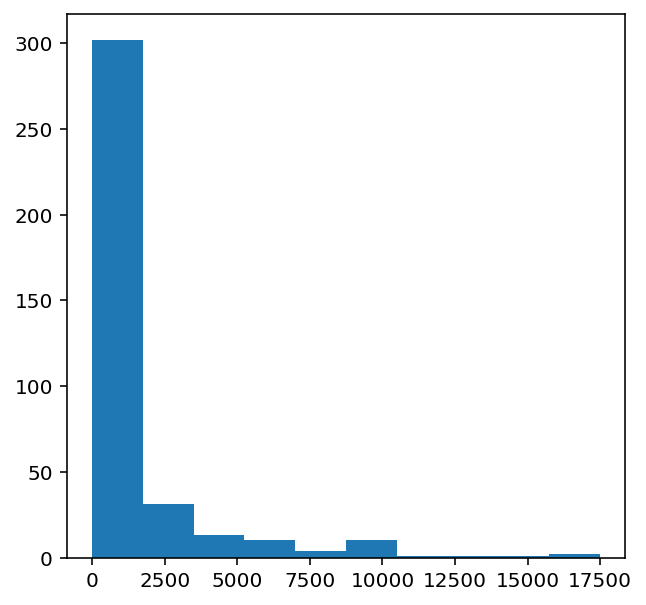

In [10]:
#importing library
from collections import Counter

#computing frequency of each note
freq = dict(Counter(notes_))

#library for visualiation
import matplotlib.pyplot as plt

#consider only the frequencies
no=[count for _,count in freq.items()]

#set the figure size
plt.figure(figsize=(5,5))

#plot
plt.hist(no)

frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

In [11]:

new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


In [12]:

no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [13]:
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [14]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [15]:
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [16]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

In [17]:
def lstm():
  model = Sequential()
  model.add(LSTM(128,return_sequences=True))
  model.add(LSTM(128))
  model.add(Dense(256))
  model.add(Activation('relu'))
  model.add(Dense(n_vocab))
  model.add(Activation('softmax'))
  model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
  return model

In [18]:
K.clear_session()
model = Sequential()
    
#embedding layer
model.add(Embedding(len(unique_x), 100, input_length=32,trainable=True)) 

model.add(Conv1D(64,3, padding='causal',activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
    
model.add(Conv1D(128,3,activation='relu',dilation_rate=2,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3,activation='relu',dilation_rate=4,padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))
          
#model.add(Conv1D(256,5,activation='relu'))    
model.add(GlobalMaxPool1D())
    
model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 32, 100)           20000     
_________________________________________________________________
conv1d (Conv1D)              (None, 32, 64)            19264     
_________________________________________________________________
dropout (Dropout)            (None, 32, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 16, 64)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 128)           24704     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 8, 128)            0

In [19]:
mc=ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True,verbose=1)
history = model.fit(np.array(x_tr),np.array(y_tr),batch_size=128,epochs=50, validation_data=(np.array(x_val),np.array(y_val)),verbose=1, callbacks=[mc])
model = load_model('best_model.h5')

Epoch 1/50
2814/2814 [==============================] - 66s 8ms/step - loss: 3.3672 - val_loss: 1.7978

Epoch 00001: val_loss improved from inf to 1.79777, saving model to best_model.h5
Epoch 2/50
2814/2814 [==============================] - 22s 8ms/step - loss: 1.7860 - val_loss: 1.0657

Epoch 00002: val_loss improved from 1.79777 to 1.06575, saving model to best_model.h5
Epoch 3/50
2814/2814 [==============================] - 22s 8ms/step - loss: 1.3469 - val_loss: 0.8094

Epoch 00003: val_loss improved from 1.06575 to 0.80936, saving model to best_model.h5
Epoch 4/50
2814/2814 [==============================] - 22s 8ms/step - loss: 1.1547 - val_loss: 0.6863

Epoch 00004: val_loss improved from 0.80936 to 0.68631, saving model to best_model.h5
Epoch 5/50
2814/2814 [==============================] - 22s 8ms/step - loss: 1.0490 - val_loss: 0.6253

Epoch 00005: val_loss improved from 0.68631 to 0.62526, saving model to best_model.h5
Epoch 6/50
2814/2814 [==============================] 

In [28]:
ind = np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions=[]
for i in range(10):

    random_music = random_music.reshape(1,no_of_timesteps)

    prob  = model.predict(random_music)[0]
    y_pred= np.argmax(prob,axis=0)
    predictions.append(y_pred)

    random_music = np.insert(random_music[0],len(random_music[0]),y_pred)
    random_music = random_music[1:]
    
print(predictions)

[171, 171, 23, 23, 23, 171, 132, 23, 22, 42]


In [29]:
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x)) 
predicted_notes = [x_int_to_note[i] for i in predictions]

In [30]:
def convert_to_midi(prediction_output):
   
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
        else:
            
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 1
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='music.mid')

In [31]:
convert_to_midi(predicted_notes)